<a href="https://colab.research.google.com/github/benhamilton88/green_design/blob/main/Customer_Perosnality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle --quiet
import os, json
from google.colab import files
files.upload()            # upload kaggle.json when prompted
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!kaggle datasets download -d imakash3011/customer-personality-analysis
!unzip -q customer-personality-analysis.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis
License(s): CC0-1.0
  0% 0.00/62.0k [00:00<?, ?B/s]
100% 62.0k/62.0k [00:00<00:00, 187MB/s]


In [10]:
import pandas as pd
df = pd.read_csv('marketing_campaign.csv', sep='\t')
print(df.shape)
df.head().style

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.000000,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.000000,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.000000,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.000000,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.000000,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


In [12]:
df['Response']= df['Response'].astype(int)
df['TenureDays']= (pd.to_datetime('2015-01-01')-pd.to_datetime(df['Dt_Customer'],dayfirst=True)).dt.days
df=df.drop(columns=['Dt_Customer'])
df['Income'] = df['Income'].fillna(df['Income'].median())

In [7]:
print(df.columns.tolist())

['ID\tYear_Birth\tEducation\tMarital_Status\tIncome\tKidhome\tTeenhome\tDt_Customer\tRecency\tMntWines\tMntFruits\tMntMeatProducts\tMntFishProducts\tMntSweetProducts\tMntGoldProds\tNumDealsPurchases\tNumWebPurchases\tNumCatalogPurchases\tNumStorePurchases\tNumWebVisitsMonth\tAcceptedCmp3\tAcceptedCmp4\tAcceptedCmp5\tAcceptedCmp1\tAcceptedCmp2\tComplain\tZ_CostContact\tZ_Revenue\tResponse']


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler, OneHotEncoder
from sklearn.compose         import ColumnTransformer
from sklearn.pipeline        import Pipeline
from sklearn.metrics         import roc_auc_score, classification_report
from sklearn.ensemble        import GradientBoostingClassifier

# numeric & categorical columns
num_cols = df.select_dtypes('number').drop('Response', axis=1).columns
cat_cols = df.select_dtypes('object').columns

X = df.drop('Response', axis=1)
y = df['Response']

numeric = Pipeline([('scaler', StandardScaler())])
categorical = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))])

prep = ColumnTransformer([
    ('num', numeric, num_cols),
    ('cat', categorical, cat_cols)
])

model = Pipeline([
    ('prep', prep),
    ('gb', GradientBoostingClassifier(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:,1]
pred  = model.predict(X_test)

print('ROC-AUC:', roc_auc_score(y_test, proba).round(3))
print(classification_report(y_test, pred))

ROC-AUC: 0.904
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       381
           1       0.77      0.40      0.53        67

    accuracy                           0.89       448
   macro avg       0.84      0.69      0.73       448
weighted avg       0.88      0.89      0.88       448



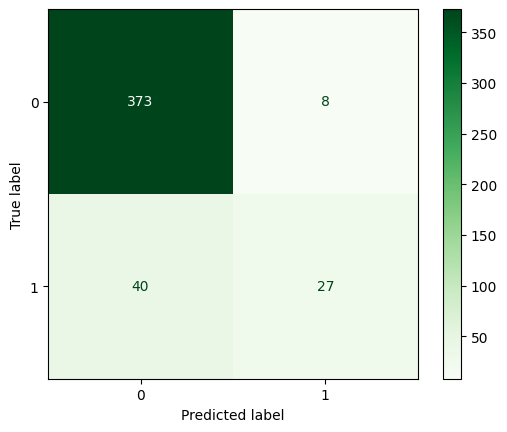

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Greens');